In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import bs4 as bs
import pickle
import requests
import time
import lxml
from datetime import datetime, timedelta

import yfinance as yf
import stockstats

import unicodedata
import json
from textblob import TextBlob

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed, RepeatVector, LSTM
# from keras.layers import CuDNNLSTM as LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from tensorflow.python.compiler.tensorrt import trt_convert as trt

Using TensorFlow backend.


In [2]:
stock_without_absolute = pd.read_pickle('./data/stock_without_absolute.pkl')
stock_with_absolute = pd.read_pickle('./data/stock_with_absolute.pkl')

label_abs_1d = pd.read_pickle('./data/label_abs_1d.pkl')
label_abs_7d = pd.read_pickle('./data/label_abs_7d.pkl')
label_abs_30d = pd.read_pickle('./data/label_abs_30d.pkl')

label_value_1d = pd.read_pickle('./data/label_value_1d.pkl')
label_value_7d = pd.read_pickle('./data/label_value_7d.pkl')
label_value_30d = pd.read_pickle('./data/label_value_30d.pkl')

In [46]:
scaler_with_abs = MinMaxScaler()
stock_with_abs_norm = scaler_with_abs.fit_transform(stock_with_absolute)

scaler_without_abs = MinMaxScaler()
stock_without_abs_norm = scaler_without_abs.fit_transform(stock_without_absolute)

#label transform
label_value_1d_scaler = MinMaxScaler()
label_value_1d_norm = label_value_1d_scaler.fit_transform(np.array(label_value_1d).reshape(-1, 1))

label_value_7d_scaler = MinMaxScaler()
label_value_7d_norm = label_value_7d_scaler.fit_transform(np.array(label_value_7d).reshape(-1, 1))

label_value_30d_scaler = MinMaxScaler()
label_value_30d_norm = label_value_30d_scaler.fit_transform(np.array(label_value_30d).reshape(-1, 1))


In [53]:
label_value_7d_norm.reshape(-1)

array([0.01370369, 0.01173069, 0.00954907, ..., 0.97876197, 0.97780225,
       0.99695403])

In [48]:
RANDOM_SEED = 10
def build_batch(train, label, pastDay=30, futureDay=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
        Y_train.append(np.array(label[i+pastDay:i+pastDay+futureDay]))
    return np.array(X_train), np.array(Y_train)

def trim_dataset(mat, batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

def result(predicted_test, test_label, predicted_train, train_label, predicted_valid, valid_label,
           file_name, decision_function, clf_name="LSTM"):
    print("Results for ", clf_name, ": ")
    acc_train = accuracy_score(train_label, predicted_train)
    acc_test = accuracy_score(test_label, predicted_test)
    acc_valid = accuracy_score(valid_label, predicted_valid)
    print("The Train Accuracy  %0.3f" % (acc_train))
    print("The Validation Accuracy  %0.3f" % (acc_valid))
    print("The Test Accuracy   %0.3f" % (acc_test ))

    print("AUC ROC : %0.3f" %( roc_auc_score(test_label, predicted_test)))
    # confusion matrix
    print("confusion matrix / precision recall scores")
    print ( confusion_matrix(test_label, predicted_test) )
    print ( classification_report(test_label, predicted_test))
    
#     f = open(file_name+'.txt','w')
#     f.write("The Train Accuracy %0.3f\n" % (acc_train))
#     f.write("The Validation Accuracy %0.3f\n" % (acc_valid))
#     f.write("The Test Accuracy %0.3f\n" % (acc_test ))
#     f.write("AUC ROC : %0.3f\n" %( roc_auc_score(test_label, predicted_test) ))
#     f.write( str(confusion_matrix(test_label, predicted_test)) + "\n")
#     f.write( str(classification_report(test_label, predicted_test)) + "\n\n")
#     f.close()
    
    pass

In [49]:
def model_train(build_model_func, PAST_DAYS, stock_data, label, hidden_layer_size, batch_size, monitor, epochs, patience=200):
    X_train_batches, y_train_batches = build_batch(stock_data, label, PAST_DAYS, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, shuffle = False, stratify = None)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle = False, stratify = None)
    
    X_train = trim_dataset(X_train, batch_size)
    y_train = trim_dataset(y_train, batch_size)
    X_valid = trim_dataset(X_valid, batch_size)
    y_valid = trim_dataset(y_valid, batch_size)
    X_test = trim_dataset(X_test, batch_size)
    y_test = trim_dataset(y_test, batch_size)
    
    
    model = build_model_func(X_train.shape, hidden_layer_size, batch_size)
    callback = EarlyStopping(monitor=monitor, patience=200, verbose=1, mode="auto")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(X_valid, y_valid), callbacks=[callback], shuffle=False)
    return model, X_train, y_train, X_valid, y_valid, X_test, y_test

In [100]:
def buildTrendModel_2stacks_true_value(shape, hidden_layer_size, batch_size):
    model = Sequential()
    model.add(LSTM(hidden_layer_size, return_sequences=True, batch_input_shape=(batch_size, shape[1], shape[2]), 
            stateful=True))
    model.add(LSTM(hidden_layer_size, return_sequences=True, stateful=True))
    model.add(Dropout(0.5))
    model.add(LSTM(hidden_layer_size, stateful=True))
    model.add(Dense(25))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mean_squared_error", optimizer='adam', metrics=['mae']) # or sgd
    return model

In [85]:
# Normalizer
train_data_normalizer = MinMaxScaler()
label_normalizer = MinMaxScaler()



In [ ]:
def model_train(build_model_func, PAST_DAYS, stock_data, label, hidden_layer_size, batch_size, monitor, epochs, patience=200):
    #Normalizer
    
    
    X_train_batches, y_train_batches = build_batch(stock_data, label, PAST_DAYS, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_train_batches, y_train_batches, test_size=0.1, shuffle = False, stratify = None)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle = False, stratify = None)
    
    X_train = trim_dataset(X_train, batch_size)
    y_train = trim_dataset(y_train, batch_size)
    X_valid = trim_dataset(X_valid, batch_size)
    y_valid = trim_dataset(y_valid, batch_size)
    X_test = trim_dataset(X_test, batch_size)
    y_test = trim_dataset(y_test, batch_size)
    
    
    model = build_model_func(X_train.shape, hidden_layer_size, batch_size)
    callback = EarlyStopping(monitor=monitor, patience=200, verbose=1, mode="auto")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(X_valid, y_valid), callbacks=[callback], shuffle=False)
    return model, X_train, y_train, X_valid, y_valid, X_test, y_test

In [104]:
batch_size = 7
model, X_train, y_train, X_valid, y_valid, X_test, y_test  = model_train(buildTrendModel_2stacks_true_value, 5, 
                                                    stock_with_abs_norm, label_value_7d, 64, batch_size, "loss", 2000, 500)
# label_value_1d_norm.reshape(-1)
predicted_test = np.array(model.predict(X_test, batch_size=batch_size))
predicted_train = np.array(model.predict(X_train, batch_size=batch_size))
predicted_valid = np.array(model.predict(X_valid, batch_size=batch_size))
print()
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=7)
print('test loss, test acc:', results)

predictions = model.predict(X_test, batch_size=7)
print('predictions shape:', predictions.shape)

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('rmse:', rmse)
predictFrame = pd.DataFrame({'prediction': predictions.reshape(X_test.shape[0]), 'true_value': y_test.reshape(X_test.shape[0])})
predictFrame

Train on 1988 samples, validate on 217 samples
Epoch 1/2000
1988/1988 [==============================] - 3s 1ms/step - loss: 369.8239 - mae: 17.2954 - val_loss: 1770.4928 - val_mae: 36.9501
Epoch 2/2000
1988/1988 [==============================] - 1s 668us/step - loss: 1377.4313 - mae: 25.9102 - val_loss: 3390.7100 - val_mae: 54.6399
Epoch 3/2000
1988/1988 [==============================] - 1s 663us/step - loss: 1273.3667 - mae: 26.3468 - val_loss: 3714.8700 - val_mae: 57.5299
Epoch 4/2000
1988/1988 [==============================] - 1s 664us/step - loss: 1254.8817 - mae: 26.3390 - val_loss: 3817.8529 - val_mae: 58.4180
Epoch 5/2000
1988/1988 [==============================] - 1s 662us/step - loss: 1253.5064 - mae: 26.4020 - val_loss: 3882.6076 - val_mae: 58.9697
Epoch 6/2000
1988/1988 [==============================] - 1s 662us/step - loss: 1253.9893 - mae: 26.4592 - val_loss: 3929.4681 - val_mae: 59.3657
Epoch 7/2000
1988/1988 [==============================] - 1s 679us/step - loss: 

1988/1988 [==============================] - 1s 651us/step - loss: 246.5505 - mae: 12.4480 - val_loss: 1349.9964 - val_mae: 31.1589
Epoch 57/2000
1988/1988 [==============================] - 1s 655us/step - loss: 281.9685 - mae: 11.8149 - val_loss: 1299.1824 - val_mae: 30.1155
Epoch 58/2000
1988/1988 [==============================] - 1s 656us/step - loss: 234.0016 - mae: 11.9336 - val_loss: 1053.3238 - val_mae: 26.1439
Epoch 59/2000
1988/1988 [==============================] - 1s 653us/step - loss: 338.0369 - mae: 14.1889 - val_loss: 781.9662 - val_mae: 21.7817
Epoch 60/2000
1988/1988 [==============================] - 1s 653us/step - loss: 277.7459 - mae: 12.6146 - val_loss: 964.2594 - val_mae: 24.8674
Epoch 61/2000
1988/1988 [==============================] - 1s 674us/step - loss: 219.8231 - mae: 10.7376 - val_loss: 1500.0917 - val_mae: 33.1965
Epoch 62/2000
1988/1988 [==============================] - 1s 666us/step - loss: 159.8673 - mae: 10.1899 - val_loss: 1456.5714 - val_mae: 32

Epoch 113/2000
1988/1988 [==============================] - 1s 654us/step - loss: 91.1073 - mae: 7.6484 - val_loss: 690.7934 - val_mae: 20.7133
Epoch 114/2000
1988/1988 [==============================] - 1s 656us/step - loss: 87.5749 - mae: 7.6448 - val_loss: 542.2975 - val_mae: 17.8625
Epoch 115/2000
1988/1988 [==============================] - 1s 652us/step - loss: 78.5885 - mae: 7.1436 - val_loss: 628.5594 - val_mae: 19.2857
Epoch 116/2000
1988/1988 [==============================] - 1s 652us/step - loss: 90.9159 - mae: 7.5065 - val_loss: 872.8355 - val_mae: 23.7838
Epoch 117/2000
1988/1988 [==============================] - 1s 661us/step - loss: 73.4405 - mae: 6.8060 - val_loss: 848.7489 - val_mae: 23.2405
Epoch 118/2000
1988/1988 [==============================] - 1s 653us/step - loss: 80.4733 - mae: 7.1798 - val_loss: 609.1282 - val_mae: 18.9709
Epoch 119/2000
1988/1988 [==============================] - 1s 652us/step - loss: 82.2276 - mae: 7.4376 - val_loss: 491.5708 - val_mae: 

Epoch 170/2000
1988/1988 [==============================] - 1s 652us/step - loss: 47.0500 - mae: 5.2572 - val_loss: 791.7519 - val_mae: 22.0210
Epoch 171/2000
1988/1988 [==============================] - 1s 652us/step - loss: 39.8282 - mae: 4.9173 - val_loss: 826.9112 - val_mae: 22.4802
Epoch 172/2000
1988/1988 [==============================] - 1s 663us/step - loss: 39.0767 - mae: 4.8336 - val_loss: 993.6591 - val_mae: 25.4373
Epoch 173/2000
1988/1988 [==============================] - 1s 655us/step - loss: 37.6212 - mae: 4.6784 - val_loss: 764.2961 - val_mae: 21.4379
Epoch 174/2000
1988/1988 [==============================] - 1s 652us/step - loss: 44.1888 - mae: 5.0026 - val_loss: 761.2793 - val_mae: 21.3986
Epoch 175/2000
1988/1988 [==============================] - 1s 656us/step - loss: 38.9975 - mae: 4.8170 - val_loss: 923.0741 - val_mae: 24.1380
Epoch 176/2000
1988/1988 [==============================] - 1s 670us/step - loss: 34.4863 - mae: 4.5212 - val_loss: 820.9698 - val_mae: 

Epoch 227/2000
1988/1988 [==============================] - 1s 666us/step - loss: 29.3092 - mae: 4.0902 - val_loss: 699.9419 - val_mae: 20.3445
Epoch 228/2000
1988/1988 [==============================] - 1s 655us/step - loss: 27.9868 - mae: 3.9885 - val_loss: 725.7630 - val_mae: 20.7668
Epoch 229/2000
1988/1988 [==============================] - 1s 658us/step - loss: 27.9309 - mae: 3.9751 - val_loss: 776.1186 - val_mae: 21.5757
Epoch 230/2000
1988/1988 [==============================] - 1s 653us/step - loss: 27.1921 - mae: 3.9097 - val_loss: 759.5072 - val_mae: 21.3109
Epoch 231/2000
1988/1988 [==============================] - 1s 653us/step - loss: 29.4043 - mae: 4.0680 - val_loss: 765.8863 - val_mae: 21.4129
Epoch 232/2000
1988/1988 [==============================] - 1s 652us/step - loss: 34.1048 - mae: 4.3886 - val_loss: 780.1234 - val_mae: 21.6381
Epoch 233/2000
1988/1988 [==============================] - 1s 654us/step - loss: 33.4326 - mae: 4.3490 - val_loss: 822.8988 - val_mae: 

Epoch 284/2000
1988/1988 [==============================] - 1s 656us/step - loss: 27.4353 - mae: 4.0900 - val_loss: 803.7415 - val_mae: 22.0571
Epoch 285/2000
1988/1988 [==============================] - 1s 655us/step - loss: 29.7484 - mae: 4.1612 - val_loss: 780.0429 - val_mae: 21.6495
Epoch 286/2000
1988/1988 [==============================] - 1s 655us/step - loss: 24.2547 - mae: 3.7368 - val_loss: 728.6325 - val_mae: 20.8161
Epoch 287/2000
1988/1988 [==============================] - 1s 654us/step - loss: 23.9560 - mae: 3.7369 - val_loss: 895.9271 - val_mae: 23.5900
Epoch 288/2000
1988/1988 [==============================] - 1s 654us/step - loss: 25.6631 - mae: 3.8436 - val_loss: 862.4259 - val_mae: 23.0443
Epoch 289/2000
1988/1988 [==============================] - 1s 653us/step - loss: 21.9254 - mae: 3.5652 - val_loss: 628.0443 - val_mae: 19.5196
Epoch 290/2000
1988/1988 [==============================] - 1s 666us/step - loss: 23.7917 - mae: 3.6971 - val_loss: 764.8367 - val_mae: 

Epoch 341/2000
1988/1988 [==============================] - 1s 660us/step - loss: 44.1008 - mae: 5.0679 - val_loss: 702.5761 - val_mae: 20.6088
Epoch 342/2000
1988/1988 [==============================] - 1s 660us/step - loss: 31.8565 - mae: 4.3572 - val_loss: 598.3045 - val_mae: 19.1682
Epoch 343/2000
1988/1988 [==============================] - 1s 717us/step - loss: 25.2946 - mae: 3.9059 - val_loss: 414.2066 - val_mae: 16.3292
Epoch 344/2000
1988/1988 [==============================] - 1s 683us/step - loss: 23.5850 - mae: 3.7045 - val_loss: 389.1602 - val_mae: 15.5205
Epoch 345/2000
1988/1988 [==============================] - 1s 667us/step - loss: 24.6021 - mae: 3.8566 - val_loss: 432.4583 - val_mae: 15.7730
Epoch 346/2000
1988/1988 [==============================] - 1s 662us/step - loss: 23.3749 - mae: 3.7832 - val_loss: 608.2668 - val_mae: 18.7264
Epoch 347/2000
1988/1988 [==============================] - 1s 667us/step - loss: 20.9742 - mae: 3.4474 - val_loss: 645.3628 - val_mae: 

Epoch 398/2000
1988/1988 [==============================] - 1s 660us/step - loss: 26.6298 - mae: 3.8634 - val_loss: 750.8607 - val_mae: 21.1673
Epoch 399/2000
1988/1988 [==============================] - 1s 660us/step - loss: 16.6642 - mae: 3.1743 - val_loss: 897.0914 - val_mae: 23.6294
Epoch 400/2000
1988/1988 [==============================] - 1s 660us/step - loss: 18.5397 - mae: 3.3102 - val_loss: 737.7817 - val_mae: 20.9581
Epoch 401/2000
1988/1988 [==============================] - 1s 659us/step - loss: 15.8273 - mae: 3.0723 - val_loss: 778.6973 - val_mae: 21.6165
Epoch 402/2000
1988/1988 [==============================] - 1s 660us/step - loss: 16.6768 - mae: 3.0922 - val_loss: 776.4755 - val_mae: 21.5862
Epoch 403/2000
1988/1988 [==============================] - 1s 662us/step - loss: 32.5124 - mae: 4.2074 - val_loss: 527.7344 - val_mae: 17.9847
Epoch 404/2000
1988/1988 [==============================] - 1s 676us/step - loss: 31.4232 - mae: 4.4147 - val_loss: 756.5714 - val_mae: 

Epoch 455/2000
1988/1988 [==============================] - 1s 659us/step - loss: 22.1414 - mae: 3.6501 - val_loss: 752.4270 - val_mae: 21.2009
Epoch 456/2000
1988/1988 [==============================] - 1s 660us/step - loss: 30.6240 - mae: 3.9328 - val_loss: 842.1544 - val_mae: 22.6996
Epoch 457/2000
1988/1988 [==============================] - 1s 667us/step - loss: 29.6610 - mae: 3.9975 - val_loss: 414.3086 - val_mae: 15.9796
Epoch 458/2000
1988/1988 [==============================] - 1s 658us/step - loss: 21.5682 - mae: 3.5100 - val_loss: 492.3760 - val_mae: 17.4007
Epoch 459/2000
1988/1988 [==============================] - 1s 658us/step - loss: 27.4925 - mae: 3.9495 - val_loss: 690.6874 - val_mae: 20.1909
Epoch 460/2000
1988/1988 [==============================] - 1s 659us/step - loss: 18.4721 - mae: 3.2968 - val_loss: 874.1186 - val_mae: 23.2192
Epoch 461/2000
1988/1988 [==============================] - 1s 661us/step - loss: 18.0227 - mae: 3.2419 - val_loss: 777.8731 - val_mae: 

Epoch 512/2000
1988/1988 [==============================] - 1s 664us/step - loss: 20.8545 - mae: 3.4879 - val_loss: 328.3353 - val_mae: 13.6557
Epoch 513/2000
1988/1988 [==============================] - 1s 663us/step - loss: 19.2717 - mae: 3.3103 - val_loss: 399.0543 - val_mae: 15.0188
Epoch 514/2000
1988/1988 [==============================] - 1s 662us/step - loss: 23.2989 - mae: 3.6198 - val_loss: 403.8900 - val_mae: 15.2797
Epoch 515/2000
1988/1988 [==============================] - 1s 671us/step - loss: 32.1698 - mae: 4.1788 - val_loss: 571.1678 - val_mae: 18.3099
Epoch 516/2000
1988/1988 [==============================] - 1s 665us/step - loss: 19.4951 - mae: 3.2540 - val_loss: 625.3795 - val_mae: 19.1628
Epoch 517/2000
1988/1988 [==============================] - 1s 665us/step - loss: 15.8806 - mae: 3.0682 - val_loss: 705.8216 - val_mae: 20.4422
Epoch 518/2000
1988/1988 [==============================] - 1s 664us/step - loss: 19.7646 - mae: 3.2913 - val_loss: 618.4125 - val_mae: 

Epoch 569/2000
1988/1988 [==============================] - 1s 679us/step - loss: 14.6811 - mae: 2.9488 - val_loss: 449.3418 - val_mae: 15.9069
Epoch 570/2000
1988/1988 [==============================] - 1s 662us/step - loss: 13.6494 - mae: 2.8796 - val_loss: 477.4226 - val_mae: 16.7277
Epoch 571/2000
1988/1988 [==============================] - 1s 662us/step - loss: 16.8627 - mae: 3.1285 - val_loss: 678.4510 - val_mae: 20.2105
Epoch 572/2000
1988/1988 [==============================] - 1s 676us/step - loss: 13.7928 - mae: 2.8266 - val_loss: 477.8581 - val_mae: 16.5895
Epoch 573/2000
1988/1988 [==============================] - 1s 664us/step - loss: 14.2834 - mae: 2.8792 - val_loss: 430.0731 - val_mae: 15.6835
Epoch 574/2000
1988/1988 [==============================] - 1s 675us/step - loss: 14.2713 - mae: 2.9816 - val_loss: 529.6296 - val_mae: 17.6797
Epoch 575/2000
1988/1988 [==============================] - 1s 662us/step - loss: 16.9962 - mae: 3.0875 - val_loss: 428.3307 - val_mae: 

Epoch 626/2000
1988/1988 [==============================] - 1s 662us/step - loss: 19.3142 - mae: 3.2203 - val_loss: 522.6708 - val_mae: 17.7667
Epoch 627/2000
1988/1988 [==============================] - 1s 663us/step - loss: 16.7524 - mae: 3.1637 - val_loss: 663.3564 - val_mae: 19.7887
Epoch 628/2000
1988/1988 [==============================] - 1s 686us/step - loss: 15.5196 - mae: 2.9448 - val_loss: 637.7780 - val_mae: 19.3604
Epoch 629/2000
1988/1988 [==============================] - 1s 664us/step - loss: 17.0317 - mae: 3.1448 - val_loss: 877.3056 - val_mae: 23.3091
Epoch 630/2000
1988/1988 [==============================] - 1s 665us/step - loss: 13.6437 - mae: 2.8950 - val_loss: 614.7251 - val_mae: 19.0448
Epoch 631/2000
1988/1988 [==============================] - 1s 666us/step - loss: 20.0223 - mae: 3.4896 - val_loss: 741.6518 - val_mae: 21.0279
Epoch 632/2000
1988/1988 [==============================] - 1s 666us/step - loss: 15.0641 - mae: 3.0155 - val_loss: 747.2292 - val_mae: 

Epoch 683/2000
1988/1988 [==============================] - 1s 659us/step - loss: 14.8627 - mae: 2.9004 - val_loss: 1221.2479 - val_mae: 28.8690
Epoch 684/2000
1988/1988 [==============================] - 1s 660us/step - loss: 10.5101 - mae: 2.5154 - val_loss: 738.3011 - val_mae: 21.0214
Epoch 685/2000
1988/1988 [==============================] - 1s 659us/step - loss: 10.7102 - mae: 2.5638 - val_loss: 803.9894 - val_mae: 22.1752
Epoch 686/2000
1988/1988 [==============================] - 1s 668us/step - loss: 12.8064 - mae: 2.8017 - val_loss: 625.0493 - val_mae: 19.1574
Epoch 687/2000
1988/1988 [==============================] - 1s 662us/step - loss: 15.6644 - mae: 3.0435 - val_loss: 1118.0844 - val_mae: 27.2003
Epoch 688/2000
1988/1988 [==============================] - 1s 662us/step - loss: 14.4387 - mae: 2.9348 - val_loss: 688.5552 - val_mae: 20.1622
Epoch 689/2000
1988/1988 [==============================] - 1s 662us/step - loss: 12.1872 - mae: 2.6801 - val_loss: 809.5135 - val_mae

Epoch 740/2000
1988/1988 [==============================] - 1s 671us/step - loss: 18.7708 - mae: 3.2110 - val_loss: 460.0954 - val_mae: 16.6285
Epoch 741/2000
1988/1988 [==============================] - 1s 658us/step - loss: 38.5659 - mae: 4.4311 - val_loss: 645.0792 - val_mae: 19.4837
Epoch 742/2000
1988/1988 [==============================] - 1s 670us/step - loss: 28.0915 - mae: 3.8362 - val_loss: 642.1708 - val_mae: 19.4374
Epoch 743/2000
1988/1988 [==============================] - 1s 667us/step - loss: 21.5801 - mae: 3.4049 - val_loss: 675.1908 - val_mae: 19.9507
Epoch 744/2000
1988/1988 [==============================] - 1s 665us/step - loss: 16.2857 - mae: 3.1380 - val_loss: 969.4983 - val_mae: 24.7676
Epoch 745/2000
1988/1988 [==============================] - 1s 663us/step - loss: 13.5310 - mae: 2.8411 - val_loss: 1099.0366 - val_mae: 26.9218
Epoch 746/2000
1988/1988 [==============================] - 1s 666us/step - loss: 12.8956 - mae: 2.8071 - val_loss: 658.7500 - val_mae:

1988/1988 [==============================] - 1s 670us/step - loss: 17.4037 - mae: 3.0959 - val_loss: 893.9256 - val_mae: 23.5465
Epoch 798/2000
1988/1988 [==============================] - 1s 659us/step - loss: 30.3260 - mae: 3.9599 - val_loss: 919.3011 - val_mae: 23.9637
Epoch 799/2000
1988/1988 [==============================] - 1s 677us/step - loss: 44.3099 - mae: 4.9105 - val_loss: 615.4877 - val_mae: 19.0661
Epoch 800/2000
1988/1988 [==============================] - 1s 664us/step - loss: 37.9168 - mae: 4.7799 - val_loss: 1109.0151 - val_mae: 27.0487
Epoch 801/2000
1988/1988 [==============================] - 1s 666us/step - loss: 18.9201 - mae: 3.2987 - val_loss: 720.0289 - val_mae: 20.6748
Epoch 802/2000
1988/1988 [==============================] - 1s 664us/step - loss: 16.5653 - mae: 3.1766 - val_loss: 948.9820 - val_mae: 24.4390
Epoch 803/2000
1988/1988 [==============================] - 1s 664us/step - loss: 14.6427 - mae: 2.9880 - val_loss: 1053.2707 - val_mae: 26.1411
Epoch

1988/1988 [==============================] - 1s 664us/step - loss: 10.9121 - mae: 2.5541 - val_loss: 848.5823 - val_mae: 22.7873
Epoch 855/2000
1988/1988 [==============================] - 1s 666us/step - loss: 10.4716 - mae: 2.5288 - val_loss: 833.1927 - val_mae: 22.5269
Epoch 856/2000
1988/1988 [==============================] - 1s 664us/step - loss: 11.0296 - mae: 2.5077 - val_loss: 917.4568 - val_mae: 23.9318
Epoch 857/2000
1988/1988 [==============================] - 1s 665us/step - loss: 9.2172 - mae: 2.2766 - val_loss: 797.1180 - val_mae: 21.9275
Epoch 858/2000
1988/1988 [==============================] - 1s 664us/step - loss: 7.3780 - mae: 2.0781 - val_loss: 716.0332 - val_mae: 20.6090
Epoch 859/2000
1988/1988 [==============================] - 1s 671us/step - loss: 7.8360 - mae: 2.1164 - val_loss: 656.4105 - val_mae: 19.6532
Epoch 860/2000
1988/1988 [==============================] - 1s 676us/step - loss: 8.3837 - mae: 2.2235 - val_loss: 778.5582 - val_mae: 21.6165
Epoch 861/2

1988/1988 [==============================] - 1s 662us/step - loss: 10.3913 - mae: 2.4616 - val_loss: 859.5170 - val_mae: 22.9714
Epoch 912/2000
1988/1988 [==============================] - 1s 662us/step - loss: 7.5917 - mae: 2.0843 - val_loss: 764.8262 - val_mae: 21.4019
Epoch 913/2000
1988/1988 [==============================] - 1s 665us/step - loss: 9.3641 - mae: 2.2337 - val_loss: 930.5288 - val_mae: 24.1397
Epoch 914/2000
1988/1988 [==============================] - 1s 679us/step - loss: 6.3297 - mae: 1.9167 - val_loss: 711.3332 - val_mae: 20.5343
Epoch 915/2000
1988/1988 [==============================] - 1s 663us/step - loss: 6.8807 - mae: 2.0238 - val_loss: 803.0717 - val_mae: 22.0322
Epoch 916/2000
1988/1988 [==============================] - 1s 664us/step - loss: 8.1751 - mae: 2.1687 - val_loss: 669.5943 - val_mae: 19.8706
Epoch 917/2000
1988/1988 [==============================] - 1s 665us/step - loss: 7.6154 - mae: 2.1440 - val_loss: 789.2250 - val_mae: 21.7986
Epoch 918/200

1988/1988 [==============================] - 1s 674us/step - loss: 7.1096 - mae: 2.0171 - val_loss: 791.2149 - val_mae: 21.8244
Epoch 969/2000
1988/1988 [==============================] - 1s 669us/step - loss: 7.6177 - mae: 2.0670 - val_loss: 727.1272 - val_mae: 20.7894
Epoch 970/2000
1988/1988 [==============================] - 1s 665us/step - loss: 8.3663 - mae: 2.1577 - val_loss: 669.7160 - val_mae: 19.8669
Epoch 971/2000
1988/1988 [==============================] - 1s 663us/step - loss: 7.5688 - mae: 2.0882 - val_loss: 871.9743 - val_mae: 23.1820
Epoch 972/2000
1988/1988 [==============================] - 1s 666us/step - loss: 7.7009 - mae: 2.1143 - val_loss: 889.6002 - val_mae: 23.4744
Epoch 973/2000
1988/1988 [==============================] - 1s 664us/step - loss: 7.3097 - mae: 2.0738 - val_loss: 664.1863 - val_mae: 19.7807
Epoch 974/2000
1988/1988 [==============================] - 1s 669us/step - loss: 7.0870 - mae: 2.0864 - val_loss: 766.8581 - val_mae: 21.4298
Epoch 975/2000

1988/1988 [==============================] - 1s 682us/step - loss: 7.6170 - mae: 2.1416 - val_loss: 758.2338 - val_mae: 21.2929
Epoch 1026/2000
1988/1988 [==============================] - 1s 661us/step - loss: 9.0105 - mae: 2.2023 - val_loss: 828.3428 - val_mae: 22.4445
Epoch 1027/2000
1988/1988 [==============================] - 1s 664us/step - loss: 6.9222 - mae: 2.0201 - val_loss: 846.1942 - val_mae: 22.7446
Epoch 1028/2000
1988/1988 [==============================] - 1s 677us/step - loss: 7.5813 - mae: 2.1010 - val_loss: 805.1490 - val_mae: 22.0589
Epoch 1029/2000
1988/1988 [==============================] - 1s 666us/step - loss: 6.1856 - mae: 1.9037 - val_loss: 819.4260 - val_mae: 22.2962
Epoch 1030/2000
1988/1988 [==============================] - 1s 680us/step - loss: 6.2458 - mae: 1.9199 - val_loss: 725.1312 - val_mae: 20.7571
Epoch 1031/2000
1988/1988 [==============================] - 1s 678us/step - loss: 5.0809 - mae: 1.7546 - val_loss: 815.6970 - val_mae: 22.2340
Epoch 10

Epoch 1082/2000
1988/1988 [==============================] - 1s 691us/step - loss: 7.0614 - mae: 2.0453 - val_loss: 735.2678 - val_mae: 20.9194
Epoch 1083/2000
1988/1988 [==============================] - 1s 686us/step - loss: 10.1242 - mae: 2.2559 - val_loss: 669.6258 - val_mae: 19.8652
Epoch 1084/2000
1988/1988 [==============================] - 1s 680us/step - loss: 8.6164 - mae: 2.1074 - val_loss: 996.8269 - val_mae: 25.2117
Epoch 1085/2000
1988/1988 [==============================] - 1s 678us/step - loss: 12.0323 - mae: 2.5968 - val_loss: 741.1416 - val_mae: 21.0200
Epoch 1086/2000
1988/1988 [==============================] - 1s 677us/step - loss: 6.9166 - mae: 2.0133 - val_loss: 655.8301 - val_mae: 19.6490
Epoch 1087/2000
1988/1988 [==============================] - 1s 689us/step - loss: 7.0503 - mae: 2.0302 - val_loss: 735.7497 - val_mae: 20.9313
Epoch 1088/2000
1988/1988 [==============================] - 1s 678us/step - loss: 6.0728 - mae: 1.9043 - val_loss: 813.8842 - val_mae

Epoch 1139/2000
1988/1988 [==============================] - 1s 665us/step - loss: 4.9924 - mae: 1.7093 - val_loss: 813.7000 - val_mae: 22.2011
Epoch 1140/2000
1988/1988 [==============================] - 1s 664us/step - loss: 5.8697 - mae: 1.7678 - val_loss: 768.9628 - val_mae: 21.4633
Epoch 1141/2000
1988/1988 [==============================] - 1s 666us/step - loss: 6.0370 - mae: 1.8440 - val_loss: 848.3969 - val_mae: 22.7821
Epoch 1142/2000
1988/1988 [==============================] - 1s 680us/step - loss: 10.3017 - mae: 2.2984 - val_loss: 839.9153 - val_mae: 22.6389
Epoch 1143/2000
1988/1988 [==============================] - 1s 665us/step - loss: 8.9368 - mae: 2.1825 - val_loss: 792.2696 - val_mae: 21.8421
Epoch 1144/2000
1988/1988 [==============================] - 1s 667us/step - loss: 8.0976 - mae: 2.1849 - val_loss: 893.1403 - val_mae: 23.5328
Epoch 1145/2000
1988/1988 [==============================] - 1s 666us/step - loss: 7.0613 - mae: 1.9901 - val_loss: 706.9785 - val_mae:

Epoch 1196/2000
1988/1988 [==============================] - 1s 680us/step - loss: 6.1683 - mae: 1.8257 - val_loss: 800.5541 - val_mae: 21.9820
Epoch 1197/2000
1988/1988 [==============================] - 1s 663us/step - loss: 4.6095 - mae: 1.6148 - val_loss: 774.7189 - val_mae: 21.5550
Epoch 1198/2000
1988/1988 [==============================] - 1s 674us/step - loss: 4.7215 - mae: 1.6824 - val_loss: 819.8434 - val_mae: 22.3032
Epoch 1199/2000
1988/1988 [==============================] - 1s 666us/step - loss: 3.5702 - mae: 1.4807 - val_loss: 803.0228 - val_mae: 22.0234
Epoch 1200/2000
1988/1988 [==============================] - 1s 664us/step - loss: 3.6296 - mae: 1.5005 - val_loss: 761.0467 - val_mae: 21.3373
Epoch 1201/2000
1988/1988 [==============================] - 1s 663us/step - loss: 3.7838 - mae: 1.5439 - val_loss: 790.0338 - val_mae: 21.8050
Epoch 1202/2000
1988/1988 [==============================] - 1s 670us/step - loss: 3.7573 - mae: 1.5366 - val_loss: 792.0139 - val_mae: 

Epoch 1253/2000
1988/1988 [==============================] - 1s 684us/step - loss: 4.0936 - mae: 1.5835 - val_loss: 770.8069 - val_mae: 21.4888
Epoch 1254/2000
1988/1988 [==============================] - 1s 709us/step - loss: 3.5550 - mae: 1.4682 - val_loss: 766.1127 - val_mae: 21.4135
Epoch 1255/2000
1988/1988 [==============================] - 1s 683us/step - loss: 4.2430 - mae: 1.5776 - val_loss: 754.0107 - val_mae: 21.2214
Epoch 1256/2000
1988/1988 [==============================] - 1s 676us/step - loss: 3.7525 - mae: 1.4873 - val_loss: 814.3916 - val_mae: 22.2127
Epoch 1257/2000
1988/1988 [==============================] - 1s 666us/step - loss: 4.2452 - mae: 1.5853 - val_loss: 796.2099 - val_mae: 21.9039
Epoch 1258/2000
1988/1988 [==============================] - 1s 669us/step - loss: 4.3329 - mae: 1.5977 - val_loss: 764.6783 - val_mae: 21.3924
Epoch 1259/2000
1988/1988 [==============================] - 1s 670us/step - loss: 6.6598 - mae: 1.8089 - val_loss: 820.0753 - val_mae: 

Epoch 1310/2000
1988/1988 [==============================] - 1s 668us/step - loss: 5.3074 - mae: 1.7179 - val_loss: 716.2386 - val_mae: 20.6106
Epoch 1311/2000
1988/1988 [==============================] - 1s 664us/step - loss: 4.5030 - mae: 1.6287 - val_loss: 815.3737 - val_mae: 22.2333
Epoch 1312/2000
1988/1988 [==============================] - 1s 669us/step - loss: 4.3744 - mae: 1.6312 - val_loss: 786.5210 - val_mae: 21.7472
Epoch 1313/2000
1988/1988 [==============================] - 1s 671us/step - loss: 4.4701 - mae: 1.5900 - val_loss: 747.4879 - val_mae: 21.1213
Epoch 1314/2000
1988/1988 [==============================] - 1s 668us/step - loss: 4.6358 - mae: 1.6815 - val_loss: 806.3252 - val_mae: 22.0790
Epoch 1315/2000
1988/1988 [==============================] - 1s 668us/step - loss: 5.0662 - mae: 1.7228 - val_loss: 764.5277 - val_mae: 21.3921
Epoch 1316/2000
1988/1988 [==============================] - 1s 669us/step - loss: 5.7006 - mae: 1.7939 - val_loss: 815.8568 - val_mae: 

Epoch 1367/2000
1988/1988 [==============================] - 1s 673us/step - loss: 3.3495 - mae: 1.4112 - val_loss: 773.4415 - val_mae: 21.5343
Epoch 1368/2000
1988/1988 [==============================] - 1s 666us/step - loss: 3.3208 - mae: 1.4144 - val_loss: 795.1902 - val_mae: 21.8915
Epoch 1369/2000
1988/1988 [==============================] - 1s 666us/step - loss: 3.0825 - mae: 1.3400 - val_loss: 769.9439 - val_mae: 21.4782
Epoch 1370/2000
1988/1988 [==============================] - 1s 683us/step - loss: 3.5758 - mae: 1.4840 - val_loss: 759.6370 - val_mae: 21.3184
Epoch 1371/2000
1988/1988 [==============================] - 1s 670us/step - loss: 4.3015 - mae: 1.5247 - val_loss: 766.9925 - val_mae: 21.4318
Epoch 1372/2000
1988/1988 [==============================] - 1s 669us/step - loss: 3.4122 - mae: 1.4599 - val_loss: 796.6763 - val_mae: 21.9167
Epoch 1373/2000
1988/1988 [==============================] - 1s 667us/step - loss: 3.3075 - mae: 1.4259 - val_loss: 785.0438 - val_mae: 

Epoch 1424/2000
1988/1988 [==============================] - 1s 680us/step - loss: 4.6308 - mae: 1.6805 - val_loss: 799.7926 - val_mae: 21.9689
Epoch 1425/2000
1988/1988 [==============================] - 1s 665us/step - loss: 4.3657 - mae: 1.6108 - val_loss: 811.4255 - val_mae: 22.1634
Epoch 1426/2000
1988/1988 [==============================] - 1s 672us/step - loss: 3.5922 - mae: 1.4656 - val_loss: 794.3959 - val_mae: 21.8781
Epoch 1427/2000
1988/1988 [==============================] - 1s 668us/step - loss: 3.2406 - mae: 1.3961 - val_loss: 786.0850 - val_mae: 21.7402
Epoch 1428/2000
1988/1988 [==============================] - 1s 669us/step - loss: 3.3772 - mae: 1.4175 - val_loss: 740.1631 - val_mae: 21.0031
Epoch 1429/2000
1988/1988 [==============================] - 1s 671us/step - loss: 2.9991 - mae: 1.3651 - val_loss: 810.0549 - val_mae: 22.1406
Epoch 1430/2000
1988/1988 [==============================] - 1s 669us/step - loss: 3.1168 - mae: 1.3600 - val_loss: 787.4740 - val_mae: 

Epoch 1481/2000
1988/1988 [==============================] - 1s 663us/step - loss: 3.0973 - mae: 1.3585 - val_loss: 822.1471 - val_mae: 22.3416
Epoch 1482/2000
1988/1988 [==============================] - 1s 666us/step - loss: 3.0778 - mae: 1.3623 - val_loss: 794.7510 - val_mae: 21.8846
Epoch 1483/2000
1988/1988 [==============================] - 1s 672us/step - loss: 3.1619 - mae: 1.3638 - val_loss: 800.1039 - val_mae: 21.9748
Epoch 1484/2000
1988/1988 [==============================] - 1s 690us/step - loss: 2.7483 - mae: 1.2750 - val_loss: 804.0783 - val_mae: 22.0439
Epoch 1485/2000
1988/1988 [==============================] - 1s 672us/step - loss: 2.5844 - mae: 1.2613 - val_loss: 768.4379 - val_mae: 21.4526
Epoch 1486/2000
1988/1988 [==============================] - 1s 671us/step - loss: 3.0359 - mae: 1.3701 - val_loss: 781.3758 - val_mae: 21.6613
Epoch 1487/2000
1988/1988 [==============================] - 1s 671us/step - loss: 2.8973 - mae: 1.3266 - val_loss: 786.3498 - val_mae: 

Epoch 1538/2000
1988/1988 [==============================] - 1s 678us/step - loss: 3.2141 - mae: 1.4208 - val_loss: 799.2861 - val_mae: 21.9610
Epoch 1539/2000
1988/1988 [==============================] - 1s 670us/step - loss: 5.3646 - mae: 1.6267 - val_loss: 715.9831 - val_mae: 20.6079
Epoch 1540/2000
1988/1988 [==============================] - 1s 679us/step - loss: 5.1277 - mae: 1.7354 - val_loss: 796.7348 - val_mae: 21.9181
Epoch 1541/2000
1988/1988 [==============================] - 1s 691us/step - loss: 3.4656 - mae: 1.4415 - val_loss: 834.3396 - val_mae: 22.5433
Epoch 1542/2000
1988/1988 [==============================] - 1s 703us/step - loss: 4.5001 - mae: 1.6328 - val_loss: 784.2989 - val_mae: 21.7108
Epoch 1543/2000
1988/1988 [==============================] - 1s 748us/step - loss: 3.6473 - mae: 1.4650 - val_loss: 772.7428 - val_mae: 21.5236
Epoch 1544/2000
1988/1988 [==============================] - 1s 700us/step - loss: 3.5584 - mae: 1.4397 - val_loss: 786.0022 - val_mae: 

Epoch 1595/2000
1988/1988 [==============================] - 1s 662us/step - loss: 2.3068 - mae: 1.1708 - val_loss: 781.9997 - val_mae: 21.6721
Epoch 1596/2000
1988/1988 [==============================] - 1s 663us/step - loss: 2.7621 - mae: 1.2638 - val_loss: 762.5522 - val_mae: 21.3614
Epoch 1597/2000
1988/1988 [==============================] - 1s 668us/step - loss: 3.4653 - mae: 1.4113 - val_loss: 773.3772 - val_mae: 21.5331
Epoch 1598/2000
1988/1988 [==============================] - 1s 674us/step - loss: 3.8073 - mae: 1.4939 - val_loss: 807.9273 - val_mae: 22.1054
Epoch 1599/2000
1988/1988 [==============================] - 1s 665us/step - loss: 3.8066 - mae: 1.4869 - val_loss: 800.4690 - val_mae: 21.9808
Epoch 1600/2000
1988/1988 [==============================] - 1s 670us/step - loss: 3.4377 - mae: 1.4316 - val_loss: 803.6355 - val_mae: 22.0338
Epoch 1601/2000
1988/1988 [==============================] - 1s 672us/step - loss: 2.7534 - mae: 1.3014 - val_loss: 797.2652 - val_mae: 

1988/1988 [==============================] - 1s 683us/step - loss: 2.5249 - mae: 1.2286 - val_loss: 774.2201 - val_mae: 21.5471
Epoch 1652/2000
1988/1988 [==============================] - 1s 669us/step - loss: 2.6076 - mae: 1.2509 - val_loss: 774.3747 - val_mae: 21.5495
Epoch 1653/2000
1988/1988 [==============================] - 1s 678us/step - loss: 2.7270 - mae: 1.2502 - val_loss: 743.5324 - val_mae: 21.0578
Epoch 1654/2000
1988/1988 [==============================] - 1s 681us/step - loss: 3.5921 - mae: 1.3981 - val_loss: 767.4238 - val_mae: 21.4386
Epoch 1655/2000
1988/1988 [==============================] - 1s 673us/step - loss: 5.4656 - mae: 1.6117 - val_loss: 739.9731 - val_mae: 21.0002
Epoch 1656/2000
1988/1988 [==============================] - 1s 668us/step - loss: 4.3373 - mae: 1.5500 - val_loss: 848.8617 - val_mae: 22.7903
Epoch 1657/2000
1988/1988 [==============================] - 1s 672us/step - loss: 5.0811 - mae: 1.7771 - val_loss: 742.7087 - val_mae: 21.0445
Epoch 16

,prediction,true_value
0,172.631714,180.940002
1,172.633636,179.550003
2,172.627258,178.580002
3,172.606232,184.820007
4,172.602844,174.720001
...,...,...
240,172.616486,265.760010
241,172.616333,267.100006
242,172.616333,266.290009
243,172.617523,263.190002


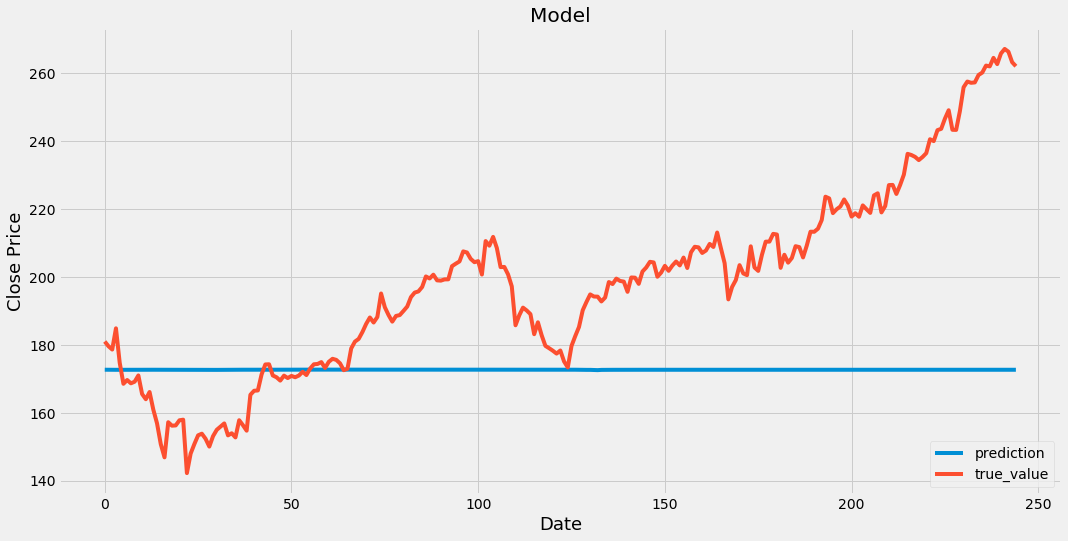

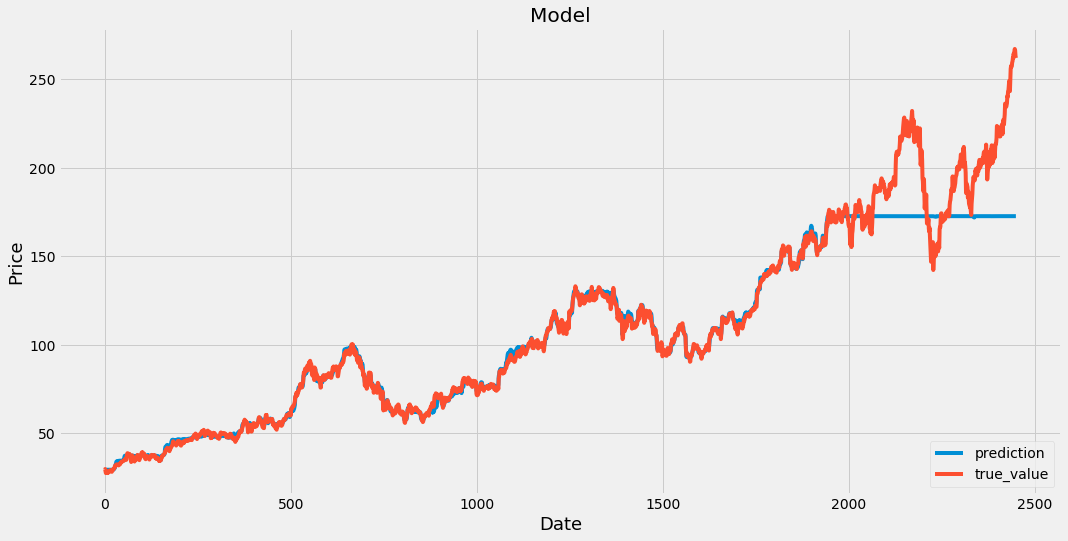

In [105]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

a = predicted_train.reshape(X_train.shape[0]).tolist()
b = predicted_valid.reshape(X_valid.shape[0]).tolist()
c = predicted_test.reshape(X_test.shape[0]).tolist()
d = y_train.reshape(X_train.shape[0]).tolist()
e = y_valid.reshape(X_valid.shape[0]).tolist()
f = y_test.reshape(X_test.shape[0]).tolist()
a.extend(b)
a.extend(c)
d.extend(e)
d.extend(f)
predictFrame = pd.DataFrame({'prediction': a, 'true_value': d})
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

In [90]:
prediction_reform = label_value_1d_scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1)
label_reform = label_value_1d_scaler.inverse_transform(y_test.reshape(-1,1)).reshape(-1)
predictFrame = pd.DataFrame({'prediction': prediction_reform, 'true_value': label_reform})
predictFrame
rmse=np.sqrt(np.mean(((prediction_reform- label_reform)**2)))
print('rmse:', rmse)

rmse: 26.941625086513923


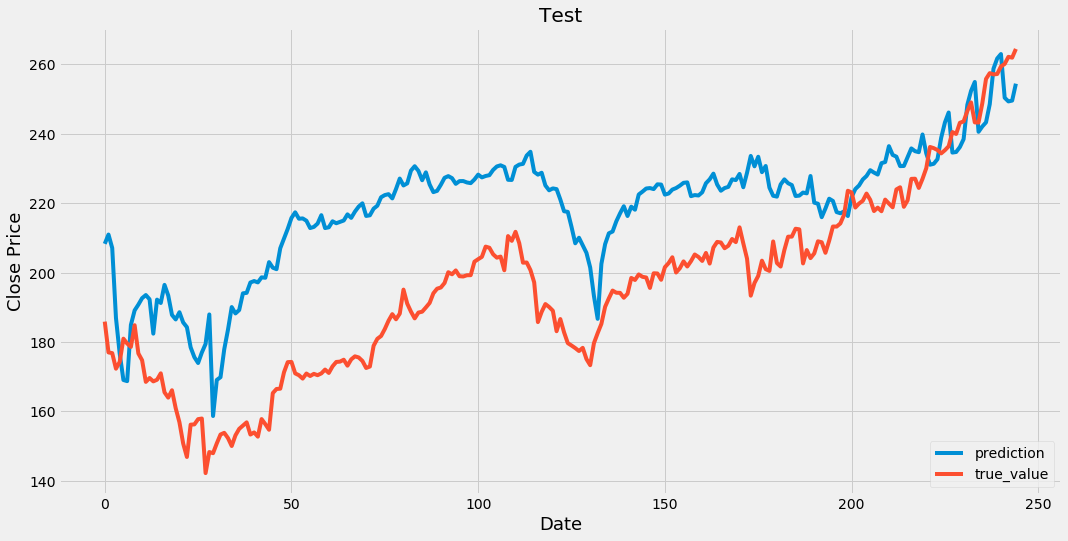

In [91]:
plt.figure(figsize=(16,8))
plt.title('Test')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()

# a = predicted_train.reshape(X_train.shape[0]).tolist()
# b = predicted_valid.reshape(X_valid.shape[0]).tolist()
# c = predicted_test.reshape(X_test.shape[0]).tolist()
# d = y_train.reshape(X_train.shape[0]).tolist()
# e = y_valid.reshape(X_valid.shape[0]).tolist()
# f = y_test.reshape(X_test.shape[0]).tolist()
# a.extend(b)
# a.extend(c)
# d.extend(e)
# d.extend(f)
# predictFrame_whole = pd.DataFrame({'prediction': a, 'true_value': d})
# plt.figure(figsize=(16,8))
# plt.title('Train + Test')
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Price', fontsize=18)
# plt.plot(predictFrame_whole)
# plt.legend(['prediction', 'true_value'], loc='lower right')
# plt.show()

# Others Work

In [32]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/Users/chinkashiwakin/anaconda3/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [38]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') 

#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
predictions = model.predict(x_test) 


Epoch 1/1
1543/1543 [==============================] - 57s 37ms/step - loss: 0.0011


In [39]:
print(predictions)
predictions = scaler.inverse_transform(predictions)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse
print(predictions)

[[0.5398555 ]
 [0.54039186]
 [0.5397175 ]
 [0.53897035]
 [0.5380685 ]
 [0.5377056 ]
 [0.5376234 ]
 [0.53792506]
 [0.538154  ]
 [0.53817606]
 [0.53782934]
 [0.5387255 ]
 [0.5409009 ]
 [0.5442297 ]
 [0.54816806]
 [0.55183053]
 [0.5542081 ]
 [0.555389  ]
 [0.55617046]
 [0.5559585 ]
 [0.55525464]
 [0.5535201 ]
 [0.55135524]
 [0.5479022 ]
 [0.54444414]
 [0.54091334]
 [0.5375225 ]
 [0.53345275]
 [0.530396  ]
 [0.5281284 ]
 [0.5271476 ]
 [0.52686626]
 [0.52790123]
 [0.52822727]
 [0.52874845]
 [0.5303601 ]
 [0.5335001 ]
 [0.5370908 ]
 [0.5395384 ]
 [0.5423715 ]
 [0.54519236]
 [0.5475221 ]
 [0.54953337]
 [0.5506844 ]
 [0.55182785]
 [0.5526342 ]
 [0.5532346 ]
 [0.5542271 ]
 [0.5560915 ]
 [0.55800223]
 [0.5583998 ]
 [0.55745   ]
 [0.5559647 ]
 [0.55900407]
 [0.5667441 ]
 [0.576671  ]
 [0.5872884 ]
 [0.5962966 ]
 [0.6034274 ]
 [0.6093215 ]
 [0.6132252 ]
 [0.61611474]
 [0.61843896]
 [0.6203805 ]
 [0.6231973 ]
 [0.6279949 ]
 [0.63248605]
 [0.636183  ]
 [0.63901347]
 [0.6412087 ]
 [0.6430725 ]
 [0.64

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
